Using device: cpu
Data loaded. Shape: (714, 31)
Number of unique target classes: 2

Starting 10-fold cross-validation with dual graph approach + GNN feature extraction...

--- Fold 1/10 ---
Extracting initial graph features for training data - Class 0
Extracting initial graph features for training data - Class 1
Extracting initial graph features for testing data - Class 0
Extracting initial graph features for testing data - Class 1
Graph for Schema: Data is empty or too small (0 samples). Returning zero features.
Shape after initial feature combination: Train_combined=(642, 50), Test_combined=(72, 50)
Preparing data for GNN...
Starting GNN training...
GNN Epoch 1/50, Loss: 0.7453
GNN Epoch 10/50, Loss: 0.0713
GNN Epoch 20/50, Loss: 0.0597
GNN Epoch 30/50, Loss: 0.0439
GNN Epoch 40/50, Loss: 0.0335
GNN Epoch 50/50, Loss: 0.0323
GNN training finished.
GNN features extracted. Train shape: (642, 32), Test shape: (72, 32)
Training the ensemble model on final features...
Fold 1 Metrics: Acc=

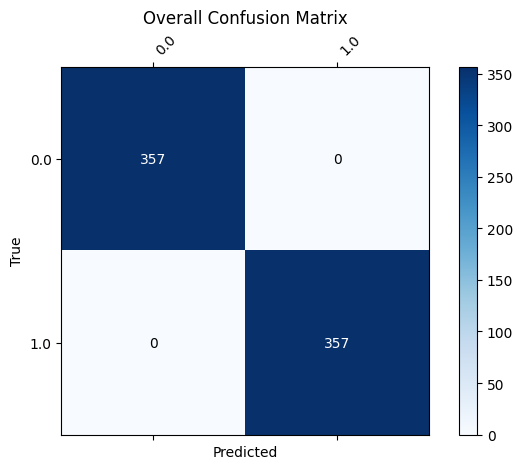


--- Script Finished ---


In [9]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import KFold 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_scipy_sparse_matrix
import scipy.sparse as sp

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# --- Configuration ---
TARGET_COLUMN = 'diagnosis'
N_SPLITS = 10 
DISTANCE_THRESHOLD = 2 


# --- GNN Configuration ---
GNN_DISTANCE_THRESHOLD = 3 
GNN_HIDDEN_DIM = 64
GNN_EMBEDDING_DIM = 32 # Output dimension of GNN features
GNN_EPOCHS = 50 #
GNN_LR = 0.01
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

def extract_graph_features(X_data, distance_thresh, graph_class_label=""):
    feature_names = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality',
                     'eigenvector_centrality', 'pagerank', 'harmonic_centrality',
                     'load_centrality', 'clustering_coefficient', 'eccentricity', 'katz_centrality']

    if X_data.empty or len(X_data) < 2:
        print(f"Graph for {graph_class_label}: Data is empty or too small ({len(X_data)} samples). Returning zero features.")
        return pd.DataFrame(columns=feature_names, index=X_data.index if hasattr(X_data, 'index') else None).fillna(0)

    original_indices = X_data.index
    X_data_reset = X_data.reset_index(drop=True) 

    try:
        dist_matrix = euclidean_distances(X_data_reset)
        adj_matrix = (dist_matrix < distance_thresh)
        np.fill_diagonal(adj_matrix, False)
        G = nx.from_numpy_array(adj_matrix)

        if G.number_of_edges() > 0:
            for u, v in G.edges():
                distance = dist_matrix[u, v]
                similarity = max(1e-9, 1.0 - (distance / distance_thresh)) 
                G.edges[u,v]['weight'] = similarity
                G.edges[u,v]['inv_weight'] = 1.0 / similarity
        

    except Exception as e:
        print(f"Error constructing graph for {graph_class_label}: {e}")
        return pd.DataFrame(columns=feature_names, index=original_indices).fillna(0)

    

    features_df = pd.DataFrame(index=X_data_reset.index)

    if G.number_of_nodes() == 0:
        features_df = pd.DataFrame(columns=feature_names, index=original_indices).fillna(0)
        return features_df

    def _calculate_centrality(graph, centrality_func, default_value=0, **kwargs):
        if graph.number_of_nodes() == 0: return default_value
        if 'weight' in kwargs and graph.number_of_edges() == 0 and centrality_func not in [nx.degree_centrality, nx.pagerank, nx.clustering, nx.eccentricity, nx.katz_centrality_numpy, nx.katz_centrality, nx.harmonic_centrality]:
            return default_value
        if (centrality_func in [nx.eigenvector_centrality_numpy, nx.eigenvector_centrality, nx.katz_centrality_numpy, nx.katz_centrality]) and graph.number_of_nodes() <= 1 :
            return default_value
        try:
            return pd.Series(centrality_func(graph, **kwargs))
        except Exception as e:
            return default_value

    features_df['degree_centrality'] = _calculate_centrality(G, nx.degree_centrality)
    features_df['betweenness_centrality'] = _calculate_centrality(G, nx.betweenness_centrality, weight='inv_weight', normalized=True, endpoints=False)
    features_df['closeness_centrality'] = _calculate_centrality(G, nx.closeness_centrality, distance='inv_weight')

    try:
        if G.number_of_nodes() > 1 and G.number_of_edges() > 0:
            features_df['eigenvector_centrality'] = pd.Series(nx.eigenvector_centrality_numpy(G, weight='weight'))
        elif G.number_of_nodes() > 1 and G.number_of_edges() > 0 :
            features_df['eigenvector_centrality'] = pd.Series(nx.eigenvector_centrality(G, weight='weight', max_iter=1000, tol=1e-05))
        else: features_df['eigenvector_centrality'] = 0
    except Exception as e: features_df['eigenvector_centrality'] = 0;

    features_df['pagerank'] = _calculate_centrality(G, nx.pagerank, alpha=0.85, weight='weight')
    features_df['harmonic_centrality'] = _calculate_centrality(G, nx.harmonic_centrality, distance='inv_weight')
    features_df['load_centrality'] = _calculate_centrality(G, nx.load_centrality, weight='inv_weight', normalized=True)
    features_df['clustering_coefficient'] = _calculate_centrality(G, nx.clustering, weight='weight')

    try:
        if G.number_of_nodes() > 0 :
            if nx.is_connected(G) or G.number_of_nodes() == 1:
                features_df['eccentricity'] = pd.Series(nx.eccentricity(G, sp=None))
            else:
                ecc_series = pd.Series(index=G.nodes(), dtype=float).fillna(float('inf'))
                for component in nx.connected_components(G):
                    subgraph = G.subgraph(component)
                    if subgraph.number_of_nodes() > 0:
                        try:
                            comp_ecc = nx.eccentricity(subgraph)
                            for node, val in comp_ecc.items():
                                ecc_series[node] = val
                        except Exception as e_ecc_comp:
                            print(f"Error computing eccentricity for component in {graph_class_label}: {e_ecc_comp}")
                features_df['eccentricity'] = ecc_series.replace(float('inf'), max(ecc_series[ecc_series != float('inf')].max()*2, 1) if any(ecc_series != float('inf')) else G.number_of_nodes())
        else: features_df['eccentricity'] = 0
    except Exception as e: features_df['eccentricity'] = 0;

    try:
        if G.number_of_nodes() > 1 and G.number_of_edges() > 0 :
            features_df['katz_centrality'] = pd.Series(nx.katz_centrality_numpy(G, alpha=0.01, weight='weight'))
        elif G.number_of_nodes() > 1 and G.number_of_edges() > 0 :
            features_df['katz_centrality'] = pd.Series(nx.katz_centrality(G, alpha=0.01, beta=1.0, weight='weight', max_iter=1000, tol=1e-05))
        else: features_df['katz_centrality'] = 0
    except Exception as e: features_df['katz_centrality'] = 0;

    features_df = features_df.fillna(0)
    features_df.index = original_indices
    return features_df


# --- GNN Architecture for Node Feature Extraction ---
class NodeFeatureGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, num_classes):
        super(NodeFeatureGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, embedding_dim) 
        self.classifier = torch.nn.Linear(embedding_dim, num_classes) 
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        embeddings = F.relu(self.conv2(x, edge_index))
        predictions = self.classifier(embeddings)
        return F.log_softmax(predictions, dim=-1), embeddings

    def get_embeddings(self, x, edge_index):
        self.eval()
        with torch.no_grad():
            x = F.relu(self.conv1(x, edge_index))
            embeddings = F.relu(self.conv2(x, edge_index))
        return embeddings

# --- Helper Function to Create PyG Data from Features ---
def create_pyg_data_from_features(features_df, labels_series, dist_thresh, device):
    if features_df.empty:
        print("Features DataFrame is empty. Cannot create PyG data.")
        return None
    x = torch.tensor(features_df.values, dtype=torch.float).to(device)
    num_nodes = len(features_df)
    if num_nodes < 2:
        print(f"Not enough nodes ({num_nodes}) to form graph for GNN. Using graph with no edges.")
        edge_index = torch.empty((2,0), dtype=torch.long).to(device)
    else:
        dist_matrix = euclidean_distances(features_df)
        adj_matrix = sp.csr_matrix(dist_matrix < dist_thresh)
        np.fill_diagonal(adj_matrix.todense(), 0) 
        edge_index, _ = from_scipy_sparse_matrix(adj_matrix)
        edge_index = edge_index.to(device)

    if labels_series is not None:
        y = torch.tensor(labels_series.values, dtype=torch.long).to(device)
        return Data(x=x, edge_index=edge_index, y=y)
    else:
        return Data(x=x, edge_index=edge_index)


# --- Function to Train GNN and Extract Features ---
def train_gnn_and_extract_node_features(gnn_model, train_data, test_data, epochs, lr, num_classes, embedding_dim, device):
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()

    print("Starting GNN training...")
    for epoch in range(epochs):
        gnn_model.train()
        optimizer.zero_grad()
        if train_data.x.shape[0] == 0 :
            print(f"Epoch {epoch+1}/{epochs}: No training data for GNN.")
            break
        if train_data.edge_index.shape[1] == 0 and train_data.x.shape[0] > 1:
            print(f"Epoch {epoch+1}/{epochs}: GNN training data has nodes but no edges. Predictions might be trivial.")

        pred_log_softmax, _ = gnn_model(train_data.x, train_data.edge_index)

        if hasattr(train_data, 'y') and train_data.y is not None and len(train_data.y) == len(pred_log_softmax):
            loss = criterion(pred_log_softmax, train_data.y)
            loss.backward()
            optimizer.step()
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f'GNN Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')
        else:
            print(f"Epoch {epoch+1}/{epochs}: Missing or mismatched labels in GNN training data. Skipping loss computation.")
            break
    print("GNN training finished.")

    gnn_model.eval()
    with torch.no_grad():
        if train_data.x.shape[0] > 0:
            train_embeddings = gnn_model.get_embeddings(train_data.x, train_data.edge_index).cpu().numpy()
        else:
            train_embeddings = np.empty((0, embedding_dim))

        if test_data.x.shape[0] > 0:
            test_embeddings = gnn_model.get_embeddings(test_data.x, test_data.edge_index).cpu().numpy()
        else:
            test_embeddings = np.empty((0, embedding_dim))

    train_gnn_features_df = pd.DataFrame(train_embeddings, columns=[f'gnn_feat_{i}' for i in range(embedding_dim)])
    test_gnn_features_df = pd.DataFrame(test_embeddings, columns=[f'gnn_feat_{i}' for i in range(embedding_dim)])

    return train_gnn_features_df, test_gnn_features_df


# --- Load Data ---
try:
    data = pd.read_csv('newdata.csv')
except FileNotFoundError:
    print("Error: 'newdata.csv' not found. Please ensure the file is in the correct directory.")
    exit()

print(f"Data loaded. Shape: {data.shape}")
if TARGET_COLUMN not in data.columns:
    print(f"Error: Target column '{TARGET_COLUMN}' not found in the data.")
    exit()

X_original = data.drop(columns=[TARGET_COLUMN])
y_series = data[TARGET_COLUMN]

label_encoder_for_y = None
if y_series.dtype == 'object' or y_series.nunique() > 2 :
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_series)
    label_encoder_for_y = le
    print(f"Target column '{TARGET_COLUMN}' encoded. Classes: {le.classes_} -> {np.unique(y_encoded)}")
else:
    y_encoded = y_series.values

num_target_classes = len(np.unique(y_encoded))
print(f"Number of unique target classes: {num_target_classes}")


kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42) 
accuracies, precisions, recalls, f1_scores, roc_aucs_list = [], [], [], [], []
all_y_true, all_y_pred_proba, all_y_pred = np.array([]), np.array([]), np.array([])

print(f"\nStarting {N_SPLITS}-fold cross-validation with dual graph approach + GNN feature extraction...\n")


for fold, (train_idx, test_idx) in enumerate(kf.split(X_original)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")
    X_train_fold_orig, y_train_fold_series = X_original.iloc[train_idx], pd.Series(y_encoded[train_idx], index=X_original.iloc[train_idx].index, name="target")
    X_test_fold_orig, y_test_fold_series = X_original.iloc[test_idx], pd.Series(y_encoded[test_idx], index=X_original.iloc[test_idx].index, name="target")

    scaler = StandardScaler()
    X_train_fold_scaled_np = scaler.fit_transform(X_train_fold_orig)
    X_test_fold_scaled_np = scaler.transform(X_test_fold_orig)

    X_train_fold_scaled_df = pd.DataFrame(X_train_fold_scaled_np, index=X_train_fold_orig.index, columns=X_train_fold_orig.columns)
    X_test_fold_scaled_df = pd.DataFrame(X_test_fold_scaled_np, index=X_test_fold_orig.index, columns=X_test_fold_orig.columns)

    print("Extracting initial graph features for training data - Class 0")
    X_train_c0 = X_train_fold_scaled_df[y_train_fold_series == 0]
    graph_features_train_c0 = extract_graph_features(X_train_c0,
                                                     distance_thresh=DISTANCE_THRESHOLD,
                                                     graph_class_label=f"Fold{fold+1}_Train_C0")
    graph_features_train_c0 = graph_features_train_c0.add_suffix('_c0')

    print("Extracting initial graph features for training data - Class 1")
    X_train_c1 = X_train_fold_scaled_df[y_train_fold_series == 1]
    graph_features_train_c1 = extract_graph_features(X_train_c1,
                                                     distance_thresh=DISTANCE_THRESHOLD,
                                                     graph_class_label=f"Fold{fold+1}_Train_C1")
    graph_features_train_c1 = graph_features_train_c1.add_suffix('_c1')

    print("Extracting initial graph features for testing data - Class 0")
    X_test_c0 = X_test_fold_scaled_df[y_test_fold_series == 0]
    graph_features_test_c0 = extract_graph_features(X_test_c0,
                                                    distance_thresh=DISTANCE_THRESHOLD,
                                                    graph_class_label=f"Fold{fold+1}_Test_C0")
    graph_features_test_c0 = graph_features_test_c0.add_suffix('_c0')

    print("Extracting initial graph features for testing data - Class 1")
    X_test_c1 = X_test_fold_scaled_df[y_test_fold_series == 1]
    graph_features_test_c1 = extract_graph_features(X_test_c1,
                                                    distance_thresh=DISTANCE_THRESHOLD,
                                                    graph_class_label=f"Fold{fold+1}_Test_C1")
    graph_features_test_c1 = graph_features_test_c1.add_suffix('_c1')

    default_feature_names = extract_graph_features(pd.DataFrame(),0, graph_class_label="Schema").columns

    if not graph_features_train_c0.empty:
        graph_features_train_c0_aligned = graph_features_train_c0.reindex(X_train_fold_scaled_df.index).fillna(0)
    else:
        cols_c0 = [f + '_c0' for f in default_feature_names]
        graph_features_train_c0_aligned = pd.DataFrame(0, index=X_train_fold_scaled_df.index, columns=cols_c0)

    if not graph_features_train_c1.empty:
        graph_features_train_c1_aligned = graph_features_train_c1.reindex(X_train_fold_scaled_df.index).fillna(0)
    else:
        cols_c1 = [f + '_c1' for f in default_feature_names]
        graph_features_train_c1_aligned = pd.DataFrame(0, index=X_train_fold_scaled_df.index, columns=cols_c1)
    X_train_combined = pd.concat([X_train_fold_scaled_df, graph_features_train_c0_aligned, graph_features_train_c1_aligned], axis=1)

    if not graph_features_test_c0.empty:
        graph_features_test_c0_aligned = graph_features_test_c0.reindex(X_test_fold_scaled_df.index).fillna(0)
    else:
        cols_c0 = [f + '_c0' for f in default_feature_names]
        graph_features_test_c0_aligned = pd.DataFrame(0, index=X_test_fold_scaled_df.index, columns=cols_c0)

    if not graph_features_test_c1.empty:
        graph_features_test_c1_aligned = graph_features_test_c1.reindex(X_test_fold_scaled_df.index).fillna(0)
    else:
        cols_c1 = [f + '_c1' for f in default_feature_names]
        graph_features_test_c1_aligned = pd.DataFrame(0, index=X_test_fold_scaled_df.index, columns=cols_c1)
    X_test_combined = pd.concat([X_test_fold_scaled_df, graph_features_test_c0_aligned, graph_features_test_c1_aligned], axis=1)

    train_cols = X_train_combined.columns
    X_test_combined = X_test_combined.reindex(columns=train_cols, fill_value=0)

    print(f"Shape after initial feature combination: Train_combined={X_train_combined.shape}, Test_combined={X_test_combined.shape}")

    print("Preparing data for GNN...")
    gnn_input_dim = X_train_combined.shape[1]

    pyg_train_data = create_pyg_data_from_features(X_train_combined, y_train_fold_series, GNN_DISTANCE_THRESHOLD, DEVICE)
    pyg_test_data = create_pyg_data_from_features(X_test_combined, None, GNN_DISTANCE_THRESHOLD, DEVICE)

    gnn_model_instance = None
    gnn_train_features_df = pd.DataFrame(index=X_train_combined.index)
    gnn_test_features_df = pd.DataFrame(index=X_test_combined.index)

    if pyg_train_data and pyg_train_data.x.shape[0] > 0 and pyg_test_data and pyg_test_data.x.shape[0] > 0:
        gnn_model_instance = NodeFeatureGNN(input_dim=gnn_input_dim,
                                            hidden_dim=GNN_HIDDEN_DIM,
                                            embedding_dim=GNN_EMBEDDING_DIM,
                                            num_classes=num_target_classes).to(DEVICE)

        gnn_train_features_df, gnn_test_features_df = train_gnn_and_extract_node_features(
            gnn_model_instance, pyg_train_data, pyg_test_data,
            epochs=GNN_EPOCHS, lr=GNN_LR,
            num_classes=num_target_classes, embedding_dim=GNN_EMBEDDING_DIM, device=DEVICE
        )
        gnn_train_features_df.index = X_train_combined.index
        gnn_test_features_df.index = X_test_combined.index
        print(f"GNN features extracted. Train shape: {gnn_train_features_df.shape}, Test shape: {gnn_test_features_df.shape}")
    else:
        print("Skipping GNN feature extraction due to empty training or test data for GNN.")
        gnn_feat_cols = [f'gnn_feat_{i}' for i in range(GNN_EMBEDDING_DIM)]
        gnn_train_features_df = pd.DataFrame(0, index=X_train_combined.index, columns=gnn_feat_cols)
        gnn_test_features_df = pd.DataFrame(0, index=X_test_combined.index, columns=gnn_feat_cols)

    X_train_final = pd.concat([X_train_combined, gnn_train_features_df], axis=1)
    X_test_final = pd.concat([X_test_combined, gnn_test_features_df], axis=1)

    final_train_cols = X_train_final.columns
    X_test_final = X_test_final.reindex(columns=final_train_cols, fill_value=0)


    if X_train_final.shape[1] != X_test_final.shape[1]:
        print(f"CRITICAL WARNING: Mismatch in final feature count! Train: {X_train_final.shape[1]}, Test: {X_test_final.shape[1]}")
        common_cols = X_train_final.columns.intersection(X_test_final.columns)
        X_train_final = X_train_final[common_cols]
        X_test_final = X_test_final[common_cols]
        print(f"Adjusted shapes after intersection: Train {X_train_final.shape}, Test {X_test_final.shape}")
        if X_train_final.empty or X_test_final.empty:
            print("CRITICAL: Feature set became empty after intersection. Check GNN feature generation and combination.")
            X_train_final = X_train_combined.copy()
            X_test_final = X_test_combined.reindex(columns=X_train_combined.columns, fill_value=0)
            print("Falling back to features before GNN step due to critical error.")

    clf1 = SVC(probability=True, random_state=42)
    clf2 = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
    clf3 = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf4 = lgb.LGBMClassifier(random_state=42, verbosity=-1)
    clf5 = RandomForestClassifier(random_state=42)
    eclf = VotingClassifier(estimators=[('svm', clf1), ('lr', clf2), ('xgb', clf3), ('lgbm', clf4), ('rf', clf5)], voting='soft')

    print("Training the ensemble model on final features...")
    if X_train_final.empty:
        print(f"Fold {fold+1}: Final training data is empty. Skipping ensemble training and prediction for this fold.")
        accuracies.append(np.nan)
        precisions.append(np.nan)
        recalls.append(np.nan)
        f1_scores.append(np.nan)
        print("-" * 30)
        continue

    eclf.fit(X_train_final, y_train_fold_series.values)

    y_pred_fold = eclf.predict(X_test_final)
    y_pred_proba_fold = eclf.predict_proba(X_test_final)[:, 1]

    all_y_true = np.concatenate((all_y_true, y_test_fold_series.values))
    all_y_pred = np.concatenate((all_y_pred, y_pred_fold))
    all_y_pred_proba = np.concatenate((all_y_pred_proba, y_pred_proba_fold))

    average_method = 'binary' if num_target_classes == 2 else 'macro'

    acc = accuracy_score(y_test_fold_series.values, y_pred_fold)
    prec = precision_score(y_test_fold_series.values, y_pred_fold, average=average_method, zero_division=0)
    rec = recall_score(y_test_fold_series.values, y_pred_fold, average=average_method, zero_division=0)
    f1 = f1_score(y_test_fold_series.values, y_pred_fold, average=average_method, zero_division=0)
    roc_auc_fold = np.nan

    try:
        if len(np.unique(y_test_fold_series.values)) > 1 :
            if num_target_classes == 2:
                roc_auc_fold = roc_auc_score(y_test_fold_series.values, y_pred_proba_fold)
            else:
                y_pred_proba_full_fold = eclf.predict_proba(X_test_final)
                roc_auc_fold = roc_auc_score(y_test_fold_series.values, y_pred_proba_full_fold, average='macro', multi_class='ovr')
        else:
            print(f"Fold {fold+1}: ROC AUC not defined as y_test_fold contains only one class.")
    except ValueError as e_roc:
        print(f"Could not calculate ROC AUC for fold {fold+1}: {e_roc}")

    accuracies.append(acc); precisions.append(prec); recalls.append(rec); f1_scores.append(f1)
    if not np.isnan(roc_auc_fold): roc_aucs_list.append(roc_auc_fold)

    print(f"Fold {fold+1} Metrics: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, ROC AUC={'N/A' if np.isnan(roc_auc_fold) else f'{roc_auc_fold:.4f}'}")
    print("-" * 30)

# --- Overall Results ---
print("\n--- Overall Cross-Validation Results ---")
print(f"Average Accuracy: {np.nanmean(accuracies):.4f} (+/- {np.nanstd(accuracies):.4f})")
print(f"Average Precision: {np.nanmean(precisions):.4f} (+/- {np.nanstd(precisions):.4f})")
print(f"Average Recall: {np.nanmean(recalls):.4f} (+/- {np.nanstd(recalls):.4f})")
print(f"Average F1-score: {np.nanmean(f1_scores):.4f} (+/- {np.nanstd(f1_scores):.4f})")

if roc_aucs_list:
    print(f"Average ROC AUC: {np.mean(roc_aucs_list):.4f} (+/- {np.std(roc_aucs_list):.4f})")
else:
    print("ROC AUC could not be reliably calculated across folds (e.g., single class in test splits or other errors).")

# --- Confusion Matrix Plotting ---
print("\n--- Overall Confusion Matrix (from all folds) ---")
if len(all_y_true) > 0 and len(all_y_pred) > 0:
    cm = confusion_matrix(all_y_true, all_y_pred)
    print(cm)
    fig_cm, ax_cm = plt.subplots()
    try:
        if label_encoder_for_y:
            class_names_display = label_encoder_for_y.classes_
        else:
            class_names_display = np.unique(all_y_true).astype(str)

        if len(class_names_display) == cm.shape[0] and len(class_names_display) == cm.shape[1]:
            cax = ax_cm.matshow(cm, cmap=plt.cm.Blues)
            fig_cm.colorbar(cax)
            ax_cm.set_xticks(np.arange(len(class_names_display)))
            ax_cm.set_yticks(np.arange(len(class_names_display)))
            ax_cm.set_xticklabels(class_names_display, rotation=45, ha="left")
            ax_cm.set_yticklabels(class_names_display)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Overall Confusion Matrix')
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax_cm.text(j, i, str(cm[i, j]), va='center', ha='center', color='black' if cm[i,j] < np.max(cm)/1.5 else 'white')
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: Class names length ({len(class_names_display)}) mismatch with CM dimensions ({cm.shape}). Plotting generically.")
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title('Overall Confusion Matrix (generic labels)')
            plt.colorbar()
            tick_marks = np.arange(cm.shape[0])
            plt.xticks(tick_marks, tick_marks); plt.yticks(tick_marks, tick_marks)
            plt.ylabel('True label'); plt.xlabel('Predicted label')
            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                    for j in range(cm.shape[1]):
                            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
            plt.tight_layout()
            plt.show()

    except Exception as e: print(f"Could not plot confusion matrix: {e}")
else: print("Not enough data to create overall confusion matrix (all_y_true or all_y_pred is empty).")


print("\n--- Script Finished ---")